<a href="https://colab.research.google.com/github/meetu30/Books-Recommendation-Engine/blob/main/FakeNewsAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download required libraries
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
#nltk.download("stopwords")
#nltk.download('wordnet')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#from gensim.models import word2vec
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import json
import os

import warnings
warnings.filterwarnings("ignore")

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install gensim

In [ ]:
#Read the csv

fileName =  "/content/drive/MyDrive/Data/tsm_label_data.csv"
Data = pd.read_csv(fileName,encoding="Latin-1")

Data.head()

,TITLE,publisher_name,content,publication_date,link,Label (Fake-0| True-1)
0,True! Sierra Leone was elected as a non-perman...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permane...,11/7/2023,https://tsmliberia.com/true-sierra-leone-was-e...,1
1,"Correct, Costa Got 8 Percent In 2017 Elections",R. Joyclyn Wea,"Claim: Henry Costa only got 3,287 votes which ...",11/7/2023,https://tsmliberia.com/correct-costa-got-8-per...,1
2,What Did Representative Foko Say about Weahâ...,Mark Mengonfia,There have been a variety of responses to a st...,8/7/2023,https://tsmliberia.com/what-did-representative...,1
3,The Post of Costa For President is Misleading,Mark Mengonfia,Claim: Henry Costa to contest the 2023 preside...,30/06/2023,https://tsmliberia.com/the-post-of-costa-for-p...,0
4,June Pidgin Edition,The Stage Media-Liberia,We have done a round of fact-checks in Liberia...,28/06/2023,https://tsmliberia.com/june-pidgin-edition/,1


In [ ]:
Data.columns

Index(['TITLE', 'publisher_name', 'content', 'publication_date', 'link',
       'Label (Fake-0| True-1)'],
      dtype='object')

In [ ]:
Data.shape

(131, 6)

In [ ]:
Data['text'] = Data['TITLE'] + Data['content']
Data.head(1)

,TITLE,publisher_name,content,publication_date,link,Label (Fake-0| True-1),text
0,True! Sierra Leone was elected as a non-perman...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permane...,11/7/2023,https://tsmliberia.com/true-sierra-leone-was-e...,1,True! Sierra Leone was elected as a non-perman...


In [ ]:
Data['publication_date'] = pd.to_datetime(Data['publication_date'])

In [ ]:
Data['year'] = Data['publication_date'].dt.year
Data['month'] = Data['publication_date'].dt.month

In [ ]:
Data.year.unique()
print("Min year in data ",Data['year'].min())
print("Max year in data ",Data['year'].max())

Min year in data  2020
Max year in data  2023


In [ ]:
Data.groupby(['year'])['TITLE'].agg('count').sort_values(ascending= False)

year
2023    73
2022    31
2021    26
2020     1
Name: TITLE, dtype: int64

In [ ]:
df=Data[Data['Label (Fake-0| True-1)']==0]
df.head(2)

,TITLE,publisher_name,content,publication_date,link,Label (Fake-0| True-1),text,year,month
3,The Post of Costa For President is Misleading,Mark Mengonfia,Claim: Henry Costa to contest the 2023 preside...,2023-06-30,https://tsmliberia.com/the-post-of-costa-for-p...,0,The Post of Costa For President is MisleadingC...,2023,6
6,Is UP Ticket a Ritual Ticket?,Bettie Johnson-Mbayo,We have tracked thirty-four social media accou...,2023-06-22,https://tsmliberia.com/is-up-ticket-a-ritual-t...,0,Is UP Ticket a Ritual Ticket?We have tracked t...,2023,6


In [ ]:
df.groupby(['month'])['TITLE'].agg('count').sort_values(ascending= False)

month
6     12
5     11
3     10
1      7
2      7
4      6
12     5
7      4
11     4
8      2
9      1
10     1
Name: TITLE, dtype: int64

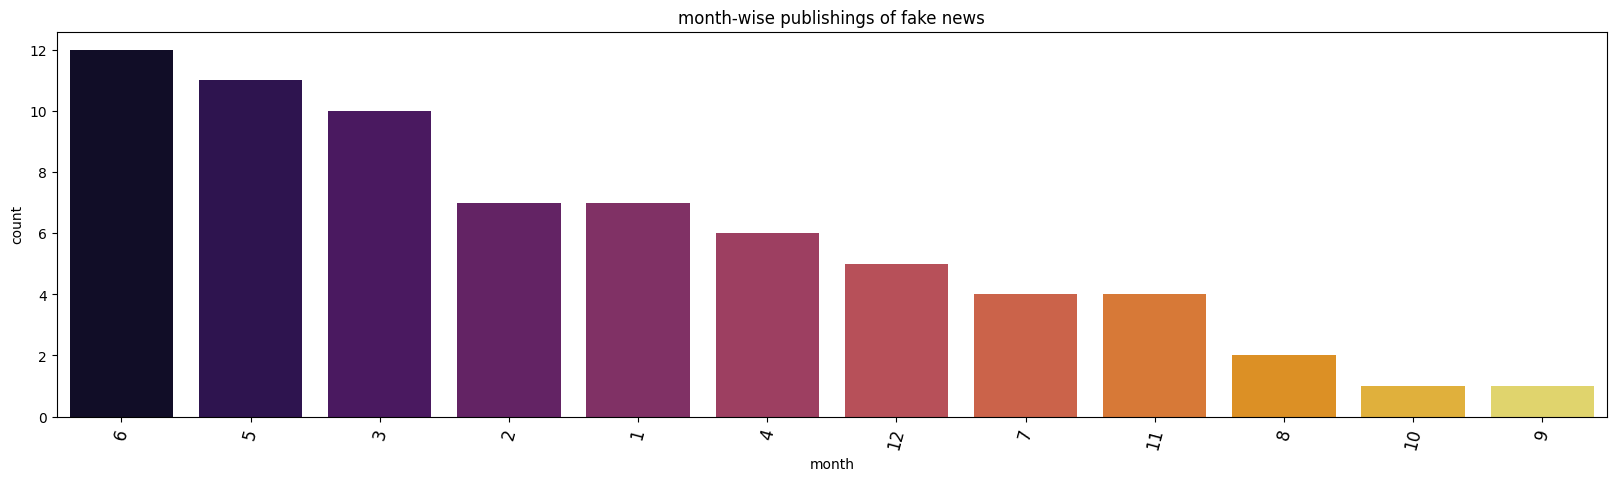

In [ ]:
# Visualise the top 10 authors with maximum number of books
plt.figure(figsize=(20,5))

sns.countplot(x = "month", data = df,
              order = df['month'].value_counts().iloc[:12].index, palette = "inferno")
plt.title("month-wise publishings of fake news")
plt.xticks(rotation = 75,fontsize = 12)
plt.show()


In [ ]:
Data.publisher_name.unique()


array(['Gloria Wleh', 'R. Joyclyn Wea', 'Mark Mengonfia',
       'The Stage Media-Liberia', 'Bettie Johnson-Mbayo', 'Maima Wright',
       'Hannah N. Geterminah', 'Alpha Daffae Senkpeni'], dtype=object)

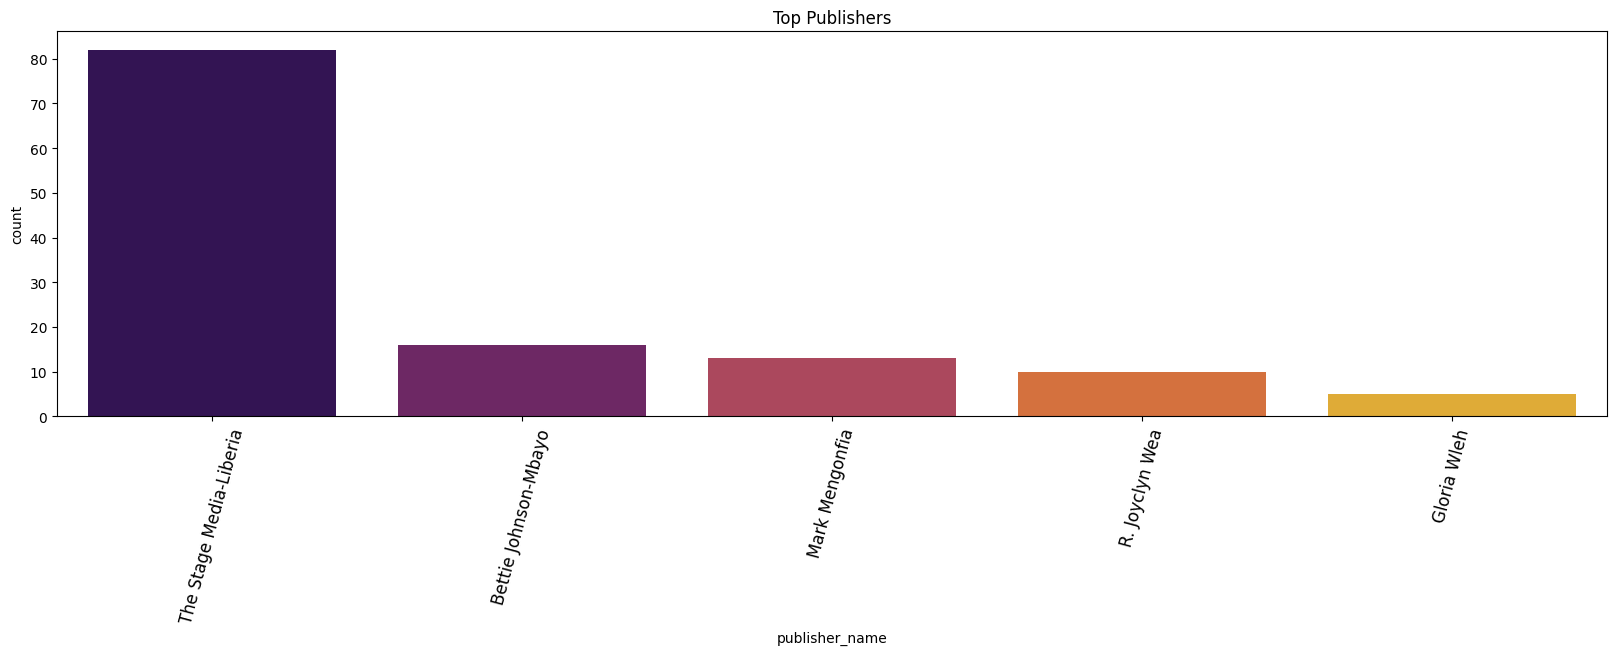

In [ ]:
# Visualise the top 10 authors with maximum number of books
plt.figure(figsize=(20,5))

sns.countplot(x = "publisher_name", data = Data,
              order = Data['publisher_name'].value_counts().iloc[:5].index, palette = "inferno")
plt.title("Top Publishers")
plt.xticks(rotation = 75,fontsize = 12)
plt.show()


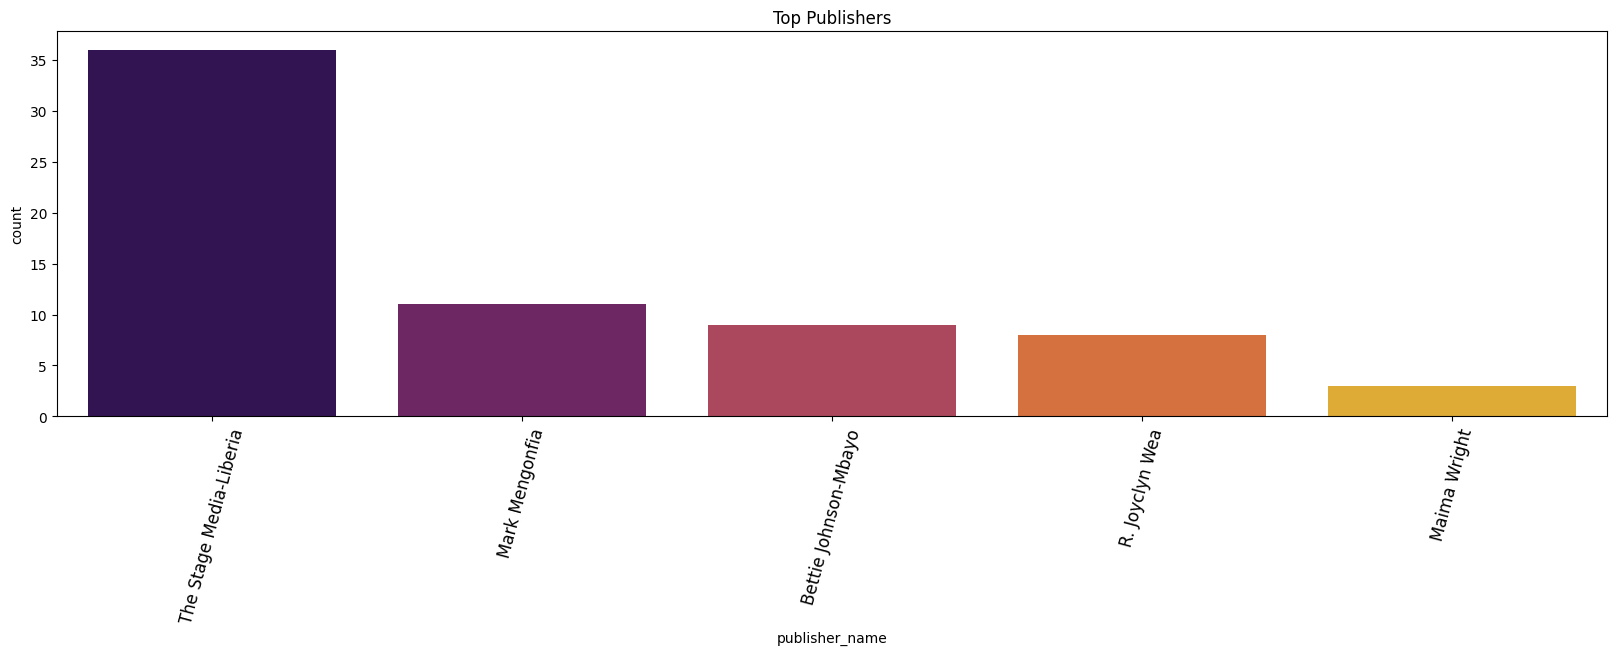

In [ ]:
# Visualise the top 10 authors with maximum number of books
plt.figure(figsize=(20,5))

sns.countplot(x = "publisher_name", data = df,
              order = df['publisher_name'].value_counts().iloc[:5].index, palette = "inferno")
plt.title("Top Publishers")
plt.xticks(rotation = 75,fontsize = 12)
plt.show()

In [ ]:
# Most fake news are published in the the month of June, and least in the month of Sept.
# Mostly fake news are in 2023 (out of 2020-2023 period of data)
# fake news are published by "The Stage Media-Liberia" followed by "Mark Mengonfia"
# Prominent keywords in fake news are X80 and X99 - basically fake news content is centered around mobile phones

In [ ]:
###################################  Data Cleaning #######################################

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = nltk.corpus.stopwords.words('english')
#stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:

def data_preprocessing(text):

    text = ' '.join(re.sub('https?://\S+|www\.\S+','',text).split())
    text = text.replace('\n', '')
    text = re.sub("[!@#$+%*:()/<.=,—']", '', text)
    text = ' '.join([word for word in text.split() if word not in stop])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text



In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
ps = nltk.PorterStemmer()

import re
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
Data['textCleaned'] = Data['text'].apply(lambda x: data_preprocessing(x.lower()))

In [ ]:
# to display more of the text content
pd.set_option('display.max_colwidth', 200)
Data.head(5)

,TITLE,publisher_name,content,publication_date,link,Label (Fake-0| True-1),text,year,month,textCleaned
0,True! Sierra Leone was elected as a non-permanent member of the...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permanent member to the UN Security Council.Verdict: True! The United Nations official website published that Sierra Leone is elected as a non-permanent memb...,2023-11-07,https://tsmliberia.com/true-sierra-leone-was-elected-as-a-non-permanent-member-of-the-un-security-council/,1,True! Sierra Leone was elected as a non-permanent member of the...Claim: Sierra Leone was voted as a non-permanent member to the UN Security Council.Verdict: True! The United Nations official webs...,2023,11,true sierra leone elected non-permanent member theclaim sierra leone voted non-permanent member un security councilverdict true united nation official website published sierra leone elected non-pe...
1,"Correct, Costa Got 8 Percent In 2017 Elections",R. Joyclyn Wea,"Claim: Henry Costa only got 3,287 votes which constitute 8%.Source: public figure and student leader Martin K. N. KollieVerdict: True, Henry Costa Obtained 8% vote in the 2017 Representative elect...",2023-11-07,https://tsmliberia.com/correct-costa-got-8-percent-in-2017-elections/,1,"Correct, Costa Got 8 Percent In 2017 ElectionsClaim: Henry Costa only got 3,287 votes which constitute 8%.Source: public figure and student leader Martin K. N. KollieVerdict: True, Henry Costa Obt...",2023,11,correct costa got 8 percent 2017 electionsclaim henry costa got 3287 vote constitute 8source public figure student leader martin k n kollieverdict true henry costa obtained 8 vote 2017 representat...
2,What Did Representative Foko Say about Weahâs One-Term Bid?,Mark Mengonfia,"There have been a variety of responses to a statement made by Frank Saah Foko, district nine of Montserrado County.Foko participated (32 mins:18 seconds) in the Montserrado County District #9 prim...",2023-08-07,https://tsmliberia.com/what-did-representative-foko-say-about-weahs-one-term-bid/,1,"What Did Representative Foko Say about Weahâs One-Term Bid?There have been a variety of responses to a statement made by Frank Saah Foko, district nine of Montserrado County.Foko participated (3...",2023,8,representative foko say weahâs one-term bid?there variety response statement made frank saah foko district nine montserrado countyfoko participated 32 mins18 second montserrado county district 9...
3,The Post of Costa For President is Misleading,Mark Mengonfia,"Claim: Henry Costa to contest the 2023 presidential election with his running mate, RiverGee senator Jonathan Sogbie on the All Liberian Party (ALP) ticket.Full Text: Political commentator and tal...",2023-06-30,https://tsmliberia.com/the-post-of-costa-for-president-is-misleading/,0,"The Post of Costa For President is MisleadingClaim: Henry Costa to contest the 2023 presidential election with his running mate, RiverGee senator Jonathan Sogbie on the All Liberian Party (ALP) ti...",2023,6,post costa president misleadingclaim henry costa contest 2023 presidential election running mate rivergee senator jonathan sogbie liberian party alp ticketfull text political commentator talk show...
4,June Pidgin Edition,The Stage Media-Liberia,"We have done a round of fact-checks in Liberian pidgin. If you see a viral claim, please send it to us +231 77 593 7658",2023-06-28,https://tsmliberia.com/june-pidgin-edition/,1,"June Pidgin EditionWe have done a round of fact-checks in Liberian pidgin. If you see a viral claim, please send it to us +231 77 593 7658",2023,6,june pidgin editionwe done round fact-checks liberian pidgin see viral claim please send u 231 77 593 7658


In [ ]:
df=Data[Data['Label (Fake-0| True-1)']==0]
#df.head(2)

Text(0.5, 1.0, 'Prominent words in news Corpus Word Cloud')

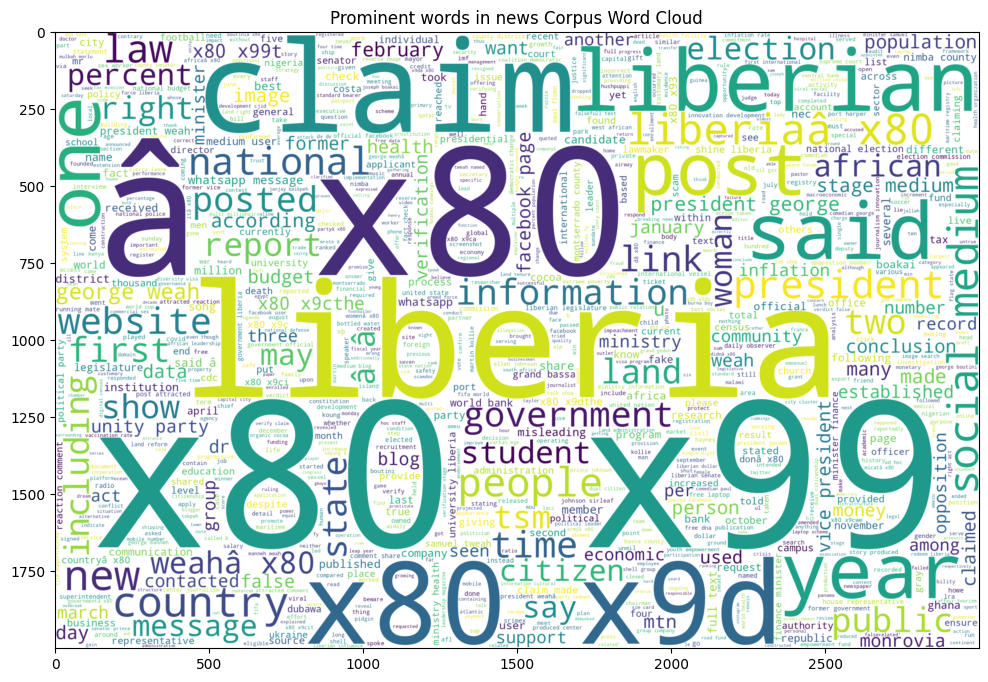

In [ ]:
contentCorpus = df.textCleaned.values
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 3000,height = 2000,background_color="white",max_words=1000).generate(str(contentCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Prominent words in news Corpus Word Cloud')

In [ ]:
tokenized_sentences_clean = [sentence.split() for sentence in Data['textCleaned'].values]

In [ ]:
Data['textCleaned_tokens'] = tokenized_sentences_clean

In [ ]:
Data.head(5)

,TITLE,publisher_name,content,publication_date,link,Label (Fake-0| True-1),text,year,month,textCleaned,textCleaned_tokens
0,True! Sierra Leone was elected as a non-permanent member of the...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permanent member to the UN Security Council.Verdict: True! The United Nations official website published that Sierra Leone is elected as a non-permanent memb...,2023-11-07,https://tsmliberia.com/true-sierra-leone-was-elected-as-a-non-permanent-member-of-the-un-security-council/,1,True! Sierra Leone was elected as a non-permanent member of the...Claim: Sierra Leone was voted as a non-permanent member to the UN Security Council.Verdict: True! The United Nations official webs...,2023,11,true sierra leone elected non-permanent member theclaim sierra leone voted non-permanent member un security councilverdict true united nation official website published sierra leone elected non-pe...,"[true, sierra, leone, elected, non-permanent, member, theclaim, sierra, leone, voted, non-permanent, member, un, security, councilverdict, true, united, nation, official, website, published, sierr..."
1,"Correct, Costa Got 8 Percent In 2017 Elections",R. Joyclyn Wea,"Claim: Henry Costa only got 3,287 votes which constitute 8%.Source: public figure and student leader Martin K. N. KollieVerdict: True, Henry Costa Obtained 8% vote in the 2017 Representative elect...",2023-11-07,https://tsmliberia.com/correct-costa-got-8-percent-in-2017-elections/,1,"Correct, Costa Got 8 Percent In 2017 ElectionsClaim: Henry Costa only got 3,287 votes which constitute 8%.Source: public figure and student leader Martin K. N. KollieVerdict: True, Henry Costa Obt...",2023,11,correct costa got 8 percent 2017 electionsclaim henry costa got 3287 vote constitute 8source public figure student leader martin k n kollieverdict true henry costa obtained 8 vote 2017 representat...,"[correct, costa, got, 8, percent, 2017, electionsclaim, henry, costa, got, 3287, vote, constitute, 8source, public, figure, student, leader, martin, k, n, kollieverdict, true, henry, costa, obtain..."
2,What Did Representative Foko Say about Weahâs One-Term Bid?,Mark Mengonfia,"There have been a variety of responses to a statement made by Frank Saah Foko, district nine of Montserrado County.Foko participated (32 mins:18 seconds) in the Montserrado County District #9 prim...",2023-08-07,https://tsmliberia.com/what-did-representative-foko-say-about-weahs-one-term-bid/,1,"What Did Representative Foko Say about Weahâs One-Term Bid?There have been a variety of responses to a statement made by Frank Saah Foko, district nine of Montserrado County.Foko participated (3...",2023,8,representative foko say weahâs one-term bid?there variety response statement made frank saah foko district nine montserrado countyfoko participated 32 mins18 second montserrado county district 9...,"[representative, foko, say, weahâs, one-term, bid?there, variety, response, statement, made, frank, saah, foko, district, nine, montserrado, countyfoko, participated, 32, mins18, second, montser..."
3,The Post of Costa For President is Misleading,Mark Mengonfia,"Claim: Henry Costa to contest the 2023 presidential election with his running mate, RiverGee senator Jonathan Sogbie on the All Liberian Party (ALP) ticket.Full Text: Political commentator and tal...",2023-06-30,https://tsmliberia.com/the-post-of-costa-for-president-is-misleading/,0,"The Post of Costa For President is MisleadingClaim: Henry Costa to contest the 2023 presidential election with his running mate, RiverGee senator Jonathan Sogbie on the All Liberian Party (ALP) ti...",2023,6,post costa president misleadingclaim henry costa contest 2023 presidential election running mate rivergee senator jonathan sogbie liberian party alp ticketfull text political commentator talk show...,"[post, costa, president, misleadingclaim, henry, costa, contest, 2023, presidential, election, running, mate, rivergee, senator, jonathan, sogbie, liberian, pa

############## Sentiment Analysis ################

In [ ]:
#!pip install word2vec
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
analyzer = SentimentIntensityAnalyzer()



In [ ]:
#Data['Sentiment Values'] = Data['textCleaned'].apply(lambda x: analyzer.polarity_scores(x))


In [ ]:
def analyze_sentiment_vader_lexicon(review):

    # analyze the sentiment for review
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    # get aggregate scores and final sentiment
    agg_score = scores['compound']
    #sentiment_Vader = 'positive' if agg_score >= threshold\
     #                              else 'negative'

    if(agg_score >= 0.05):
        sentiment_Vader = 'High Risk'
    elif(agg_score <= -0.05):
        sentiment_Vader = 'Low Risk'
    else:
        sentiment_Vader = 'neutral'


    return sentiment_Vader

In [ ]:
Data["sentiment_Vader"] = Data["textCleaned"].apply(lambda x: analyze_sentiment_vader_lexicon(x) )

In [ ]:
#Total number of different actual sentiments
actualNeg = len(Data[Data['sentiment_Vader']=='High Risk'])
actualPos = len(Data[Data['sentiment_Vader']=='Low Risk'])
actualNeu = len(Data[Data['sentiment_Vader']=='neutral'])
print("Number of positive sentiments is  " + str(actualPos))
print("Number of negative sentiments is " + str(actualNeg))
print("Number of neutral sentiments is " + str(actualNeu))

Number of positive sentiments is  27
Number of negative sentiments is 103
Number of neutral sentiments is 1


<Axes: xlabel='sentiment_Vader', ylabel='count'>

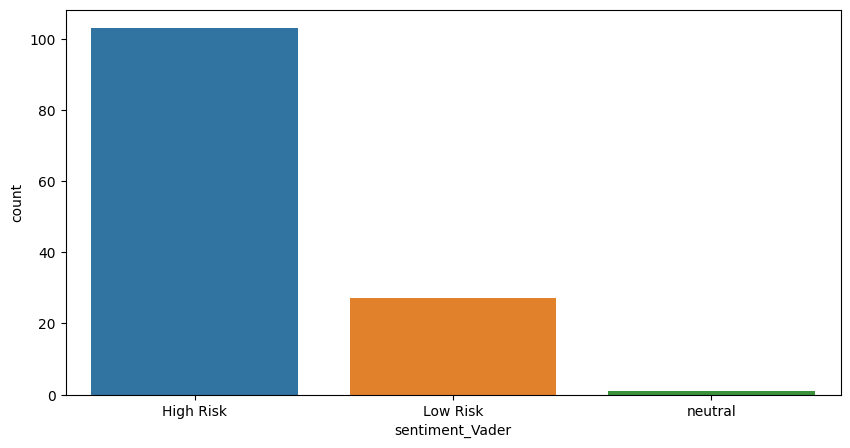

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.countplot(x='sentiment_Vader',data=Data)

In [ ]:
#Count of texts in each category of sentiments
temp = Data.groupby('sentiment_Vader').count()['textCleaned'].reset_index().sort_values(by='textCleaned',ascending=False)
temp.style.background_gradient(cmap='Greens')

,sentiment_Vader,textCleaned
0,High Risk,103
1,Low Risk,27
2,neutral,1


In [ ]:
df=Data[Data['Label (Fake-0| True-1)']==0]

In [ ]:
#Count of texts in each category of sentiments
temp = df.groupby('sentiment_Vader').count()['textCleaned'].reset_index().sort_values(by='textCleaned',ascending=False)
temp.style.background_gradient(cmap='Greens')

,sentiment_Vader,textCleaned
0,High Risk,58
1,Low Risk,11
2,neutral,1


############ POS tagging to extract prominent verbs #############

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
# POS Tagging
def pos_tagging(string):
  pos_tags = []
  string = nlp(string)
  for token in string:
    if(token.tag_ == 'VB' or token.tag_ == 'VBD' or token.tag_ == 'VBG' or token.tag_ == 'VBN' or token.tag_ == 'MD' or token.tag_ == 'VBP' or token.tag_ == 'VBZ'):
      pos_tags.append(token.text)
  pos_tags = list(set(pos_tags))
  #return ','.join(pos_tags)
  return pos_tags

In [ ]:
Data['POS_Verbs'] = Data['textCleaned'].apply(lambda text : pos_tagging(text))


In [ ]:
Data.head()

,TITLE,publisher_name,content,publication_date,link,Label (Fake-0| True-1),text,year,month,textCleaned,textCleaned_tokens,Sentiment Values,sentiment_Vader,POS_Verbs
0,True! Sierra Leone was elected as a non-permanent member of the...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permanent member to the UN Security Council.Verdict: True! The United Nations official website published that Sierra Leone is elected as a non-permanent memb...,2023-11-07,https://tsmliberia.com/true-sierra-leone-was-elected-as-a-non-permanent-member-of-the-un-security-council/,1,True! Sierra Leone was elected as a non-permanent member of the...Claim: Sierra Leone was voted as a non-permanent member to the UN Security Council.Verdict: True! The United Nations official webs...,2023,11,true sierra leone elected non-permanent member theclaim sierra leone voted non-permanent member un security councilverdict true united nation official website published sierra leone elected non-pe...,"[true, sierra, leone, elected, non-permanent, member, theclaim, sierra, leone, voted, non-permanent, member, un, security, councilverdict, true, united, nation, official, website, published, sierr...","{'neg': 0.086, 'neu': 0.719, 'pos': 0.196, 'compound': 0.9895}",High Risk,"[take, clash, imposing, elected, making, including, receive, termed, seen, heard, said, get, published, dismissing, granting, call, furthers, congratulating, become, recommends, authorising, condu..."
1,"Correct, Costa Got 8 Percent In 2017 Elections",R. Joyclyn Wea,"Claim: Henry Costa only got 3,287 votes which constitute 8%.Source: public figure and student leader Martin K. N. KollieVerdict: True, Henry Costa Obtained 8% vote in the 2017 Representative elect...",2023-11-07,https://tsmliberia.com/correct-costa-got-8-percent-in-2017-elections/,1,"Correct, Costa Got 8 Percent In 2017 ElectionsClaim: Henry Costa only got 3,287 votes which constitute 8%.Source: public figure and student leader Martin K. N. KollieVerdict: True, Henry Costa Obt...",2023,11,correct costa got 8 percent 2017 electionsclaim henry costa got 3287 vote constitute 8source public figure student leader martin k n kollieverdict true henry costa obtained 8 vote 2017 representat...,"[correct, costa, got, 8, percent, 2017, electionsclaim, henry, costa, got, 3287, vote, constitute, 8source, public, figure, student, leader, martin, k, n, kollieverdict, true, henry, costa, obtain...","{'neg': 0.028, 'neu': 0.869, 'pos': 0.103, 'compound': 0.9266}",High Risk,"[enforcing, obtained, holding, posted, constituting, revealed, known, charge, taking, said, established, claim, become, served, provided, constitutes, partyâs, turned, live, constitute, came, su..."
2,What Did Representative Foko Say about Weahâs One-Term Bid?,Mark Mengonfia,"There have been a variety of responses to a statement made by Frank Saah Foko, district nine of Montserrado County.Foko participated (32 mins:18 seconds) in the Montserrado County District #9 prim...",2023-08-07,https://tsmliberia.com/what-did-representative-foko-say-about-weahs-one-term-bid/,1,"What Did Representative Foko Say about Weahâs One-Term Bid?There have been a variety of responses to a statement made by Frank Saah Foko, district nine of Montserrado County.Foko participated (3...",2023,8,representative foko say weahâs one-term bid?there variety response statement made frank saah foko district nine montserrado countyfoko participated 32 mins18 second montserrado county district 9...,"[representative, foko, say, weahâs, one-term, bid?there, variety, response, statement, made, frank, saah, foko, district, nine, montserrado, countyfoko, participated, 32, mins18, second, montser...","{'neg': 0.025, 'neu': 0.814, 'pos': 0.161, 'compound': 0.9599}",High Risk,"[becomes, questioned, posted, collect, say, received, appreciating, said, make, ensure, conducted, presidentârelated, confirmed, participated, contacted, would, intended, form, made, announced, ..."
3,The Post of Costa For President is Mislea

Text(0.5, 1.0, 'Prominent words in news Corpus Word Cloud')

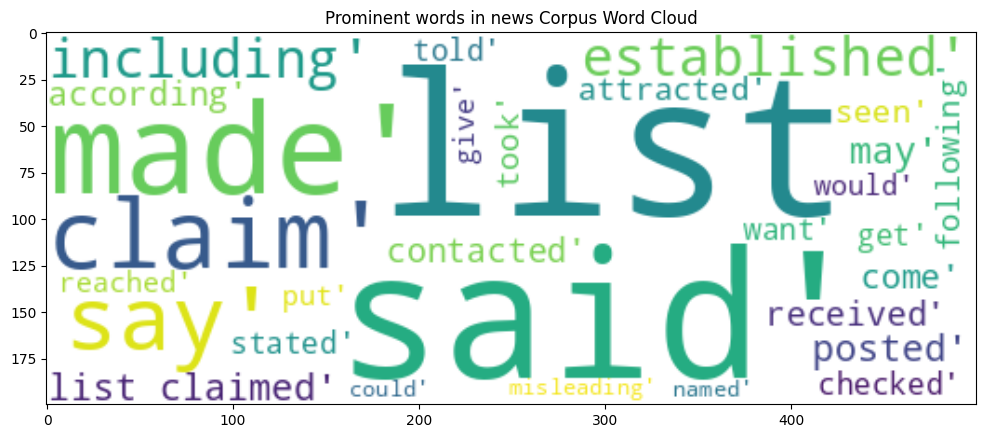

In [ ]:
contentCorpus = df.POS_Verbs.values
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 500,height = 200,background_color="white",max_words=30).generate(str(contentCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Prominent words in news Corpus Word Cloud')

############# similar words ##############

In [ ]:
#!pip install Word2Vec
from gensim.models import word2vec


In [ ]:
tokenized_sentences_clean = [sentence.split() for sentence in Data['textCleaned'].values]

In [ ]:
model = word2vec.Word2Vec(tokenized_sentences_clean, vector_size = 100, min_count=1)

In [ ]:
def buildWordVector(word_list, size):
    #function to average all words vectors in a given paragraph
    vec = np.zeros(size)
    count = 0.
    for word in word_list:
        if word in model.wv:
            vec += model.wv[word]
            count += 1.
    if count != 0:
        vec /= count
    return vec

In [ ]:
Data['text_embedding'] = Data['textCleaned_tokens'].apply(lambda x: buildWordVector(x, size = 100))

In [ ]:
similar = model.wv.most_similar('enforcing')
print(similar)

[('chayren', 0.38307416439056396), ('hungary', 0.3589528799057007), ('size', 0.35323184728622437), ('refuted', 0.3406216502189636), ('obed', 0.3382544219493866), ('co-partner', 0.3367215096950531), ('timeline', 0.33546483516693115), ('cardsource', 0.33425790071487427), ('wouldnâ\x80\x99t', 0.3278212249279022), ('prisonthe', 0.32541292905807495)]
